In [40]:

import pandas as pd
from feature_engine.selection import DropCorrelatedFeatures
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import MinMaxScaler

import utils
from utils import pct_change, draw_pct_change

In [41]:
OUTLIER_RUL_THRESHOLD = 280
CORRELATION_THRESHOLD = 0.7
ENGINE_ID = 1
ROLLING_AVERAGE_WINDOW = 5
df = utils.load_data("CMAPSSData/train_FD001.txt")
df.describe()
PCT_CHANGE_PERIODS = 20
MAPIE_ALPHAS = [0.1]

In [42]:
df.nunique()

engine_id                                100
time                                     362
operational_setting_1                    158
operational_setting_2                     13
operational_setting_3                      1
Fan_inlet_temperature                      1
LPC_outlet_temperature                   310
HPC_outlet_temperature                  3012
LPT_outlet_temperature                  4051
Fan_inlet_Pressure                         1
bypass-duct_pressure                       2
HPC_outlet_pressure                      513
Physical_fan_speed                        53
Physical_core_speed                     6403
Engine_pressure_ratio(                     1
HPC_outlet_Static_pressure               159
Ratio_of_fuel_flow_to_Ps30               427
Corrected_fan_speed                       56
Corrected_core_speed                    6078
Bypass_Ratio                            1918
Burner_fuel-air_ratio                      1
Bleed_Enthalpy                            13
Required_f

## drop constant or nearly constant columns

In [43]:
# df = df.loc[:, df.nunique() > 13]

### Max cycles histogram


<Axes: >

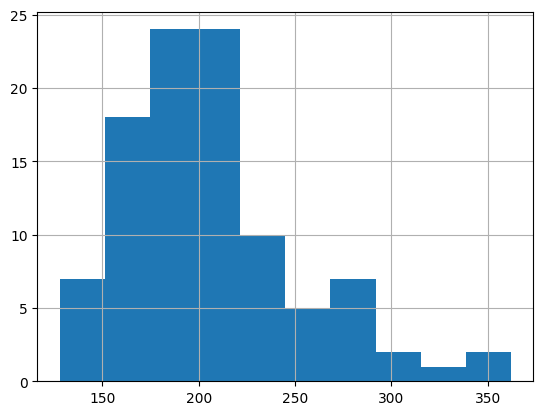

In [44]:
df.groupby(["engine_id"])["time"].max().hist()

### Drop outliers

<Axes: >

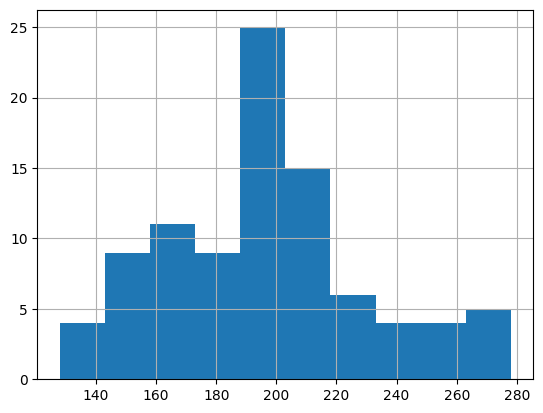

In [45]:
ids_to_drop = df.loc[df['time'] > OUTLIER_RUL_THRESHOLD, 'engine_id'].unique()
df = df[~df['engine_id'].isin(ids_to_drop)]
df.groupby(["engine_id"])["time"].max().hist()

In [46]:
features = list(df.columns)
features.remove('time')
features.remove('engine_id')
y = df.groupby('engine_id')['time'].transform('max') - df['time']
features_df = df[features]
features_df

,operational_setting_1,operational_setting_2,operational_setting_3,Fan_inlet_temperature,LPC_outlet_temperature,HPC_outlet_temperature,LPT_outlet_temperature,Fan_inlet_Pressure,bypass-duct_pressure,HPC_outlet_pressure,...,Ratio_of_fuel_flow_to_Ps30,Corrected_fan_speed,Corrected_core_speed,Bypass_Ratio,Burner_fuel-air_ratio,Bleed_Enthalpy,Required_fan_speed,Required_fan_conversion_speed,High-pressure_turbines_Cool_air_flow,Low-pressure_turbines_Cool_air_flow
0,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [47]:

f_scores, p_values = f_regression(features_df, y)
threshold = 0.05
significant_features = features_df.columns[p_values < threshold]
dropped_features = features_df.columns[p_values >= threshold]
df_filtered = df[significant_features]

print("Selected Features:")
print(significant_features)
print("Dropped features:")
print(dropped_features)
df = pd.merge(df[['time', 'engine_id']], df_filtered, left_index=True, right_index=True)

Selected Features:
Index(['LPC_outlet_temperature', 'HPC_outlet_temperature',
       'LPT_outlet_temperature', 'bypass-duct_pressure', 'HPC_outlet_pressure',
       'Physical_fan_speed', 'Physical_core_speed',
       'HPC_outlet_Static_pressure', 'Ratio_of_fuel_flow_to_Ps30',
       'Corrected_fan_speed', 'Corrected_core_speed', 'Bypass_Ratio',
       'Bleed_Enthalpy', 'High-pressure_turbines_Cool_air_flow',
       'Low-pressure_turbines_Cool_air_flow'],
      dtype='object')
Dropped features:
Index(['operational_setting_1', 'operational_setting_2',
       'operational_setting_3', 'Fan_inlet_temperature', 'Fan_inlet_Pressure',
       'Engine_pressure_ratio(', 'Burner_fuel-air_ratio', 'Required_fan_speed',
       'Required_fan_conversion_speed'],
      dtype='object')


/Users/pszmurlo/Documents/pw/PBAD1/.venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:379: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)


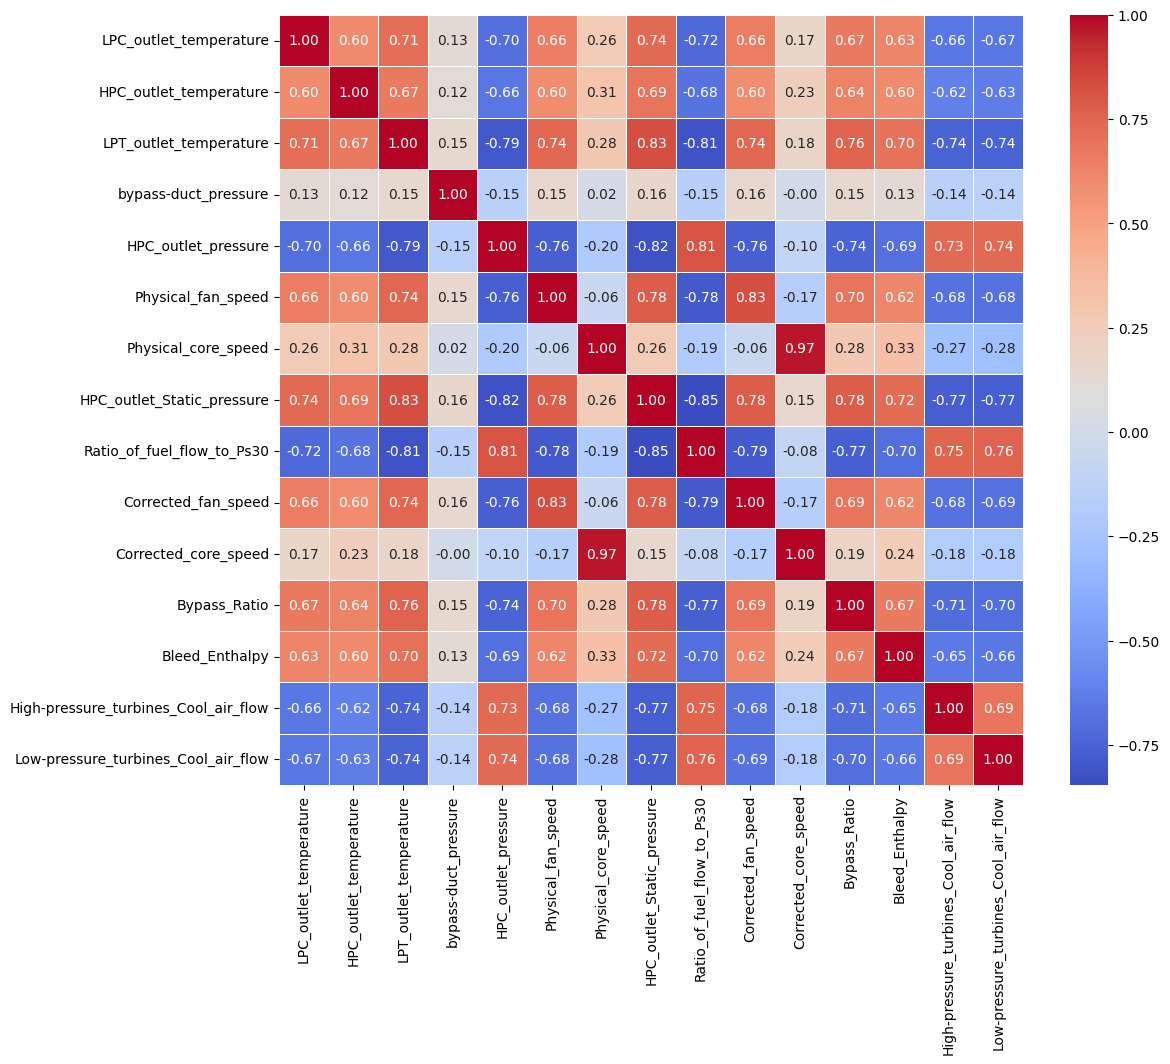

In [48]:
utils.draw_corr(df[significant_features])

In [49]:
features_df = df.drop(['time', 'engine_id'], axis=1)
dcf = DropCorrelatedFeatures(threshold=CORRELATION_THRESHOLD)
features_df = dcf.fit_transform(features_df)
df = pd.merge(df[['engine_id', 'time']], features_df, left_index=True, right_index=True)
df.columns


Index(['engine_id', 'time', 'LPC_outlet_temperature', 'HPC_outlet_temperature',
       'bypass-duct_pressure', 'Corrected_fan_speed', 'Corrected_core_speed',
       'Bypass_Ratio', 'Bleed_Enthalpy'],
      dtype='object')

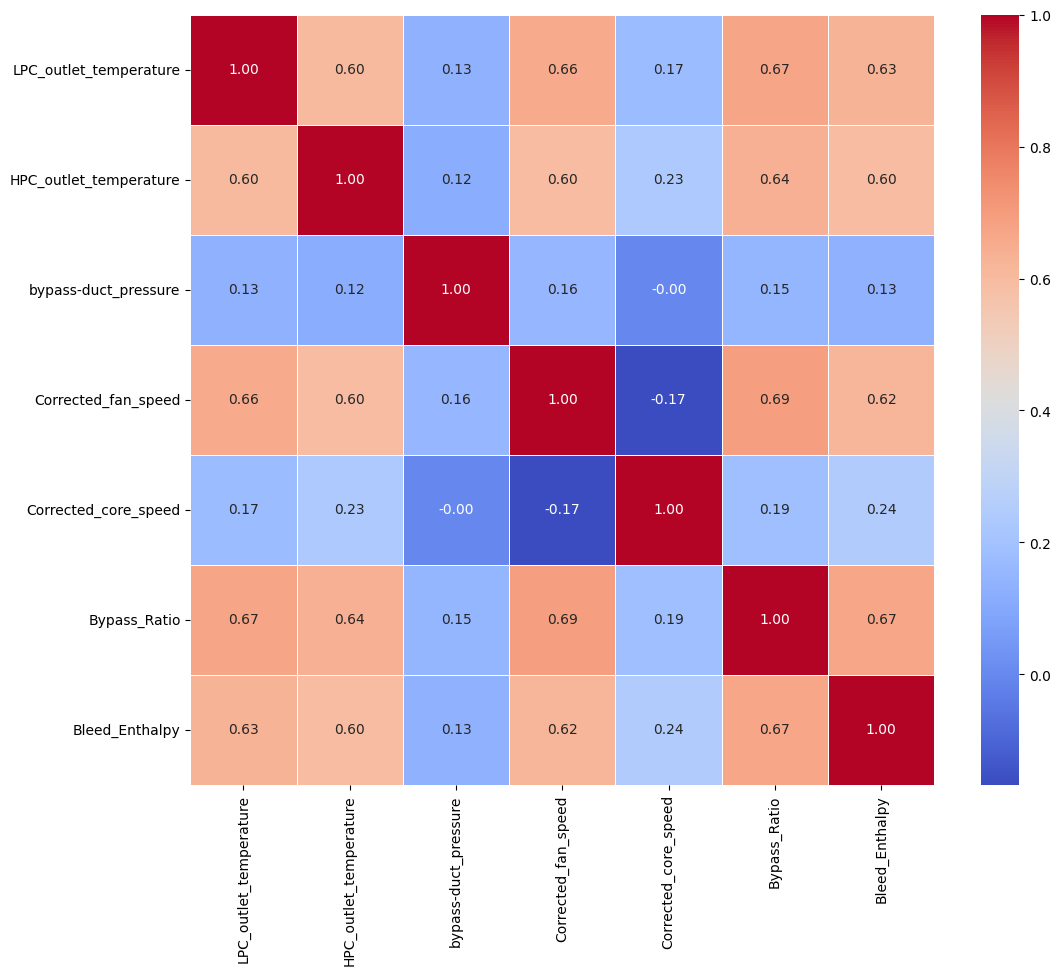

In [50]:
utils.draw_corr(features_df)

In [51]:
scaler = MinMaxScaler()
df = df.drop(["bypass-duct_pressure"], axis=1)  # prawie stałe wartości ?
cols = df.columns[df.columns != "engine_id"]
cols = cols[cols != "time"]
cols = cols[cols != "rul"]
df[cols] = scaler.fit_transform(df[cols])
df.describe()

,engine_id,time,LPC_outlet_temperature,HPC_outlet_temperature,Corrected_fan_speed,Corrected_core_speed,Bypass_Ratio,Bleed_Enthalpy
count,18133.000000,18133.000000,18133.000000,18133.000000,18133.000000,18133.000000,18133.000000,18133.000000
mean,48.704848,102.038990,0.446281,0.426822,0.320605,0.226014,0.454134,0.436805
std,28.276056,61.987076,0.149716,0.133175,0.106545,0.102807,0.143620,0.128648
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,50.000000,0.340361,0.334205,0.250000,0.167252,0.350519,0.333333
50%,48.000000,99.000000,0.436747,0.418138,0.323529,0.208845,0.442863,0.416667
75%,74.000000,149.000000,0.542169,0.511227,0.382353,0.250026,0.543671,0.500000
max,100.000000,278.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


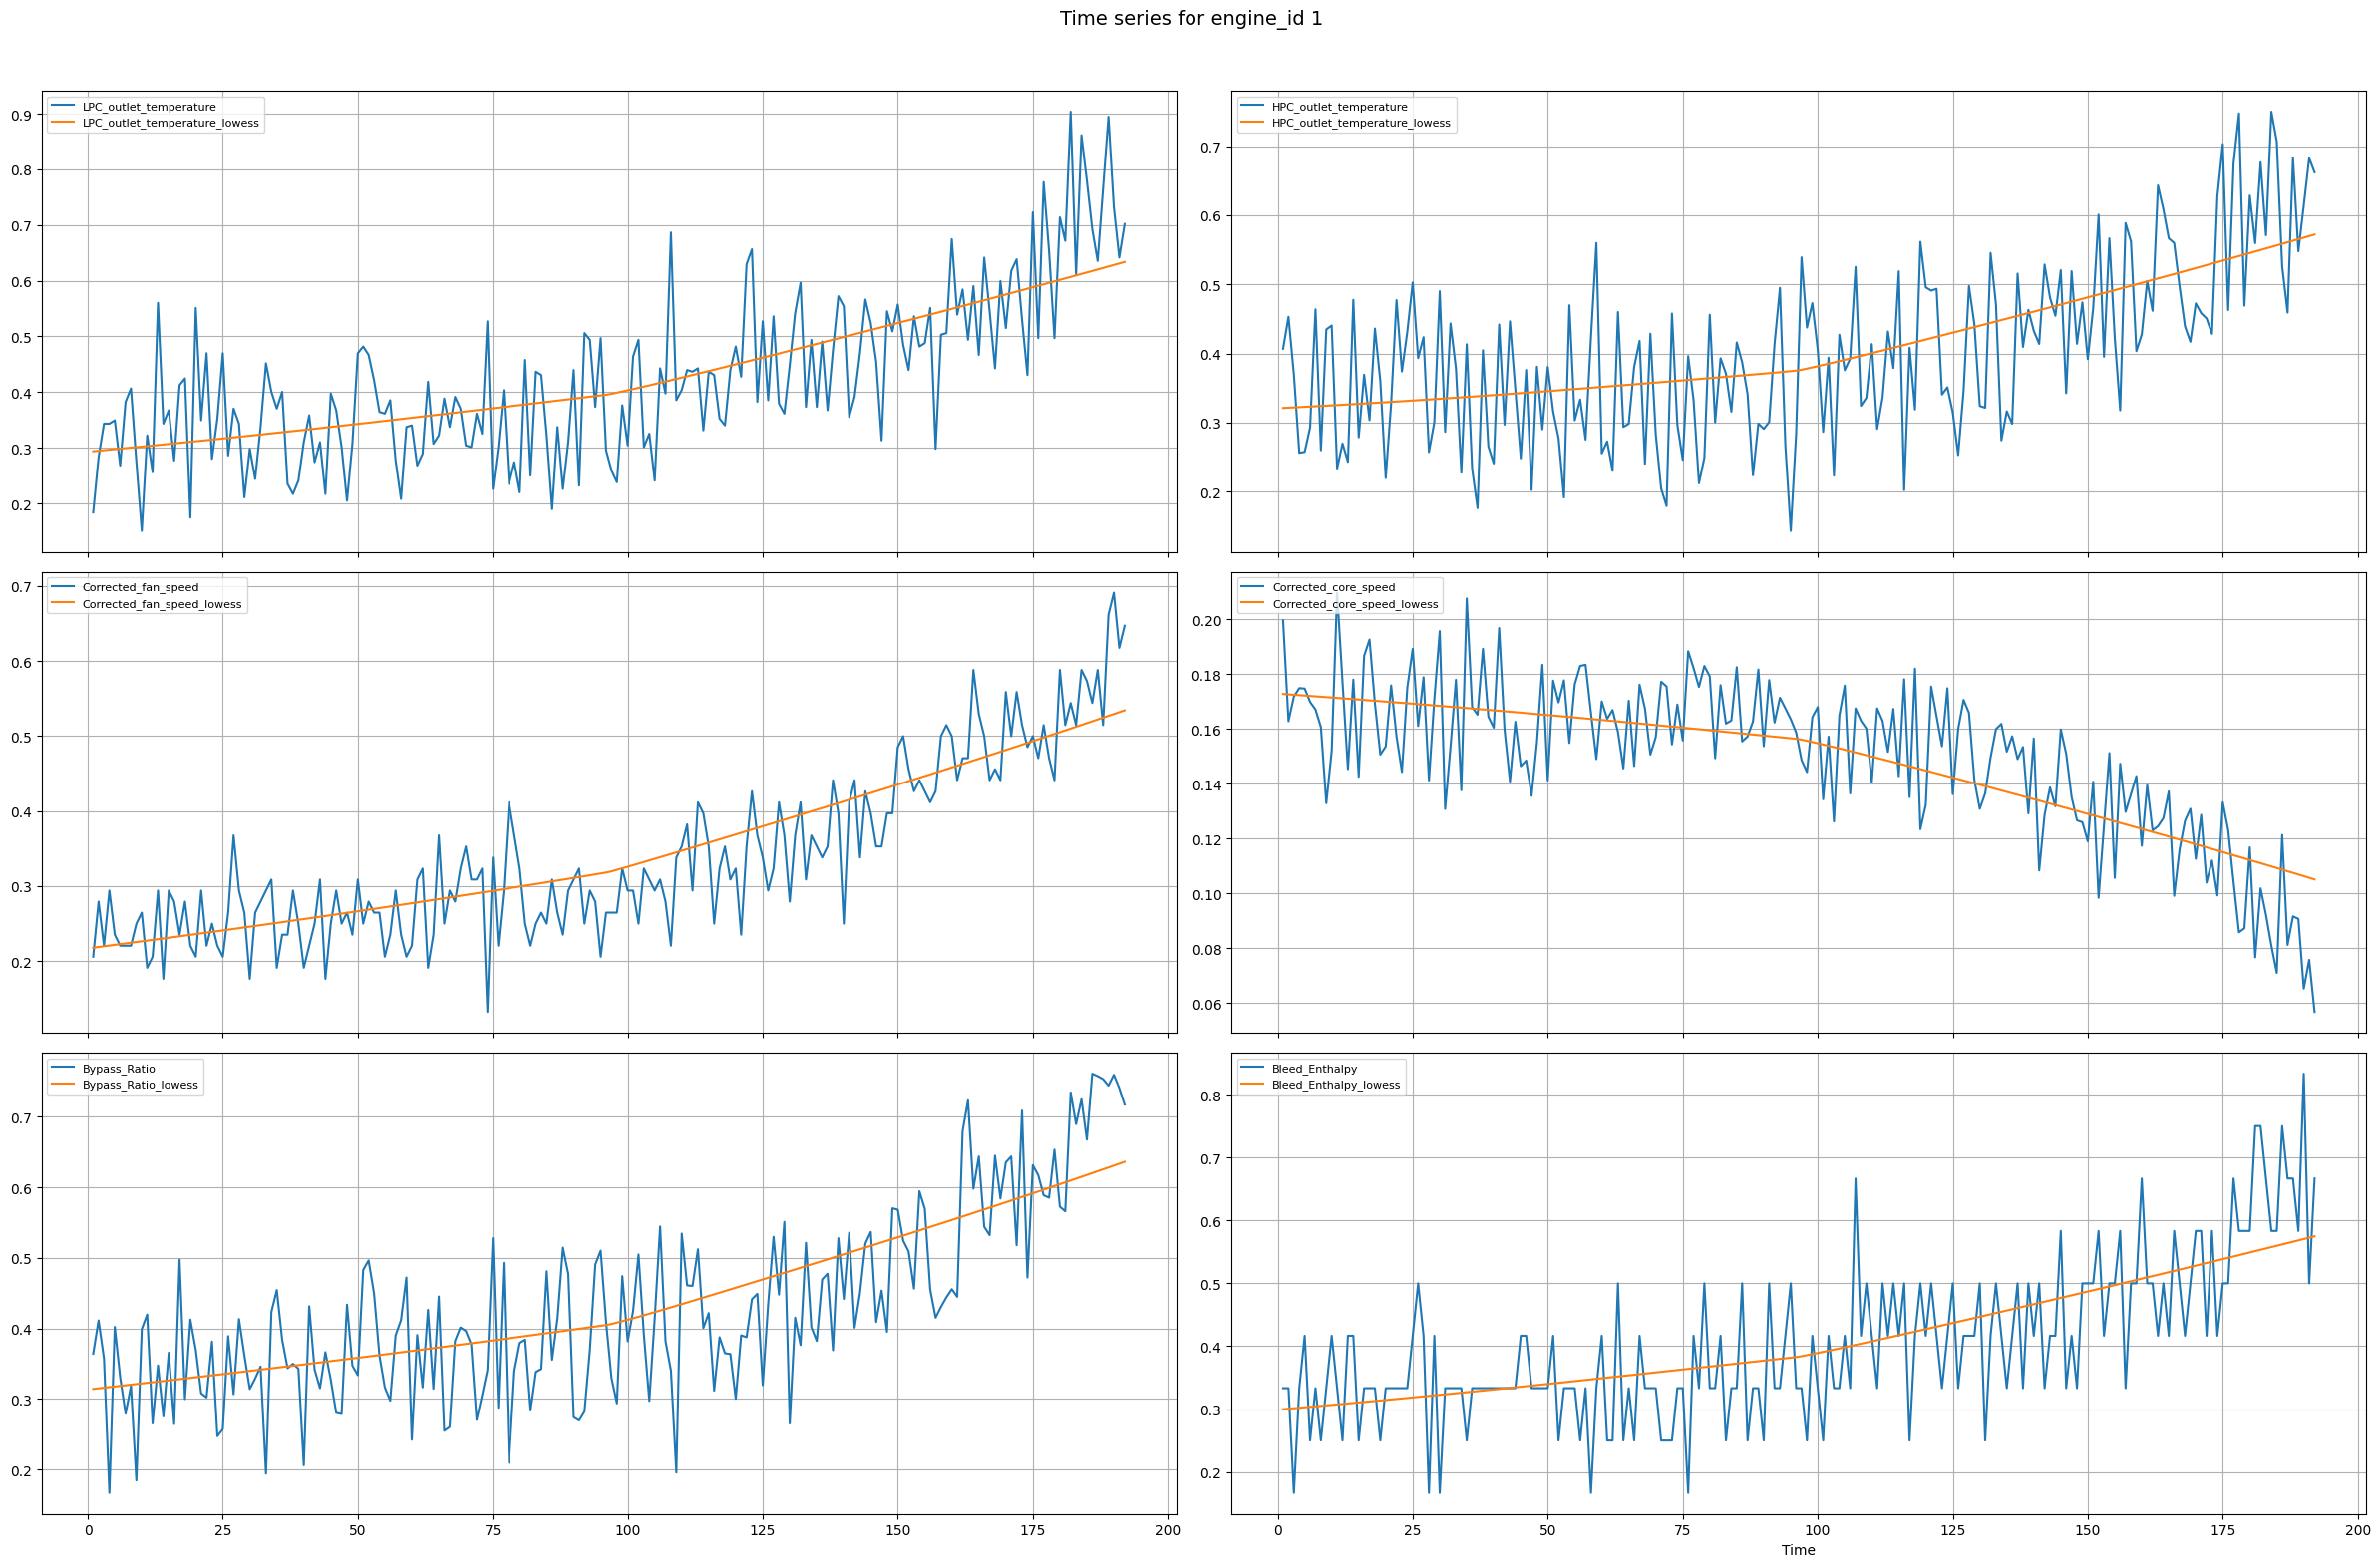

In [52]:
df_with_smooth_cols = utils.lowess_features(df, ENGINE_ID)
utils.draw_time_series(df_with_smooth_cols, ENGINE_ID)

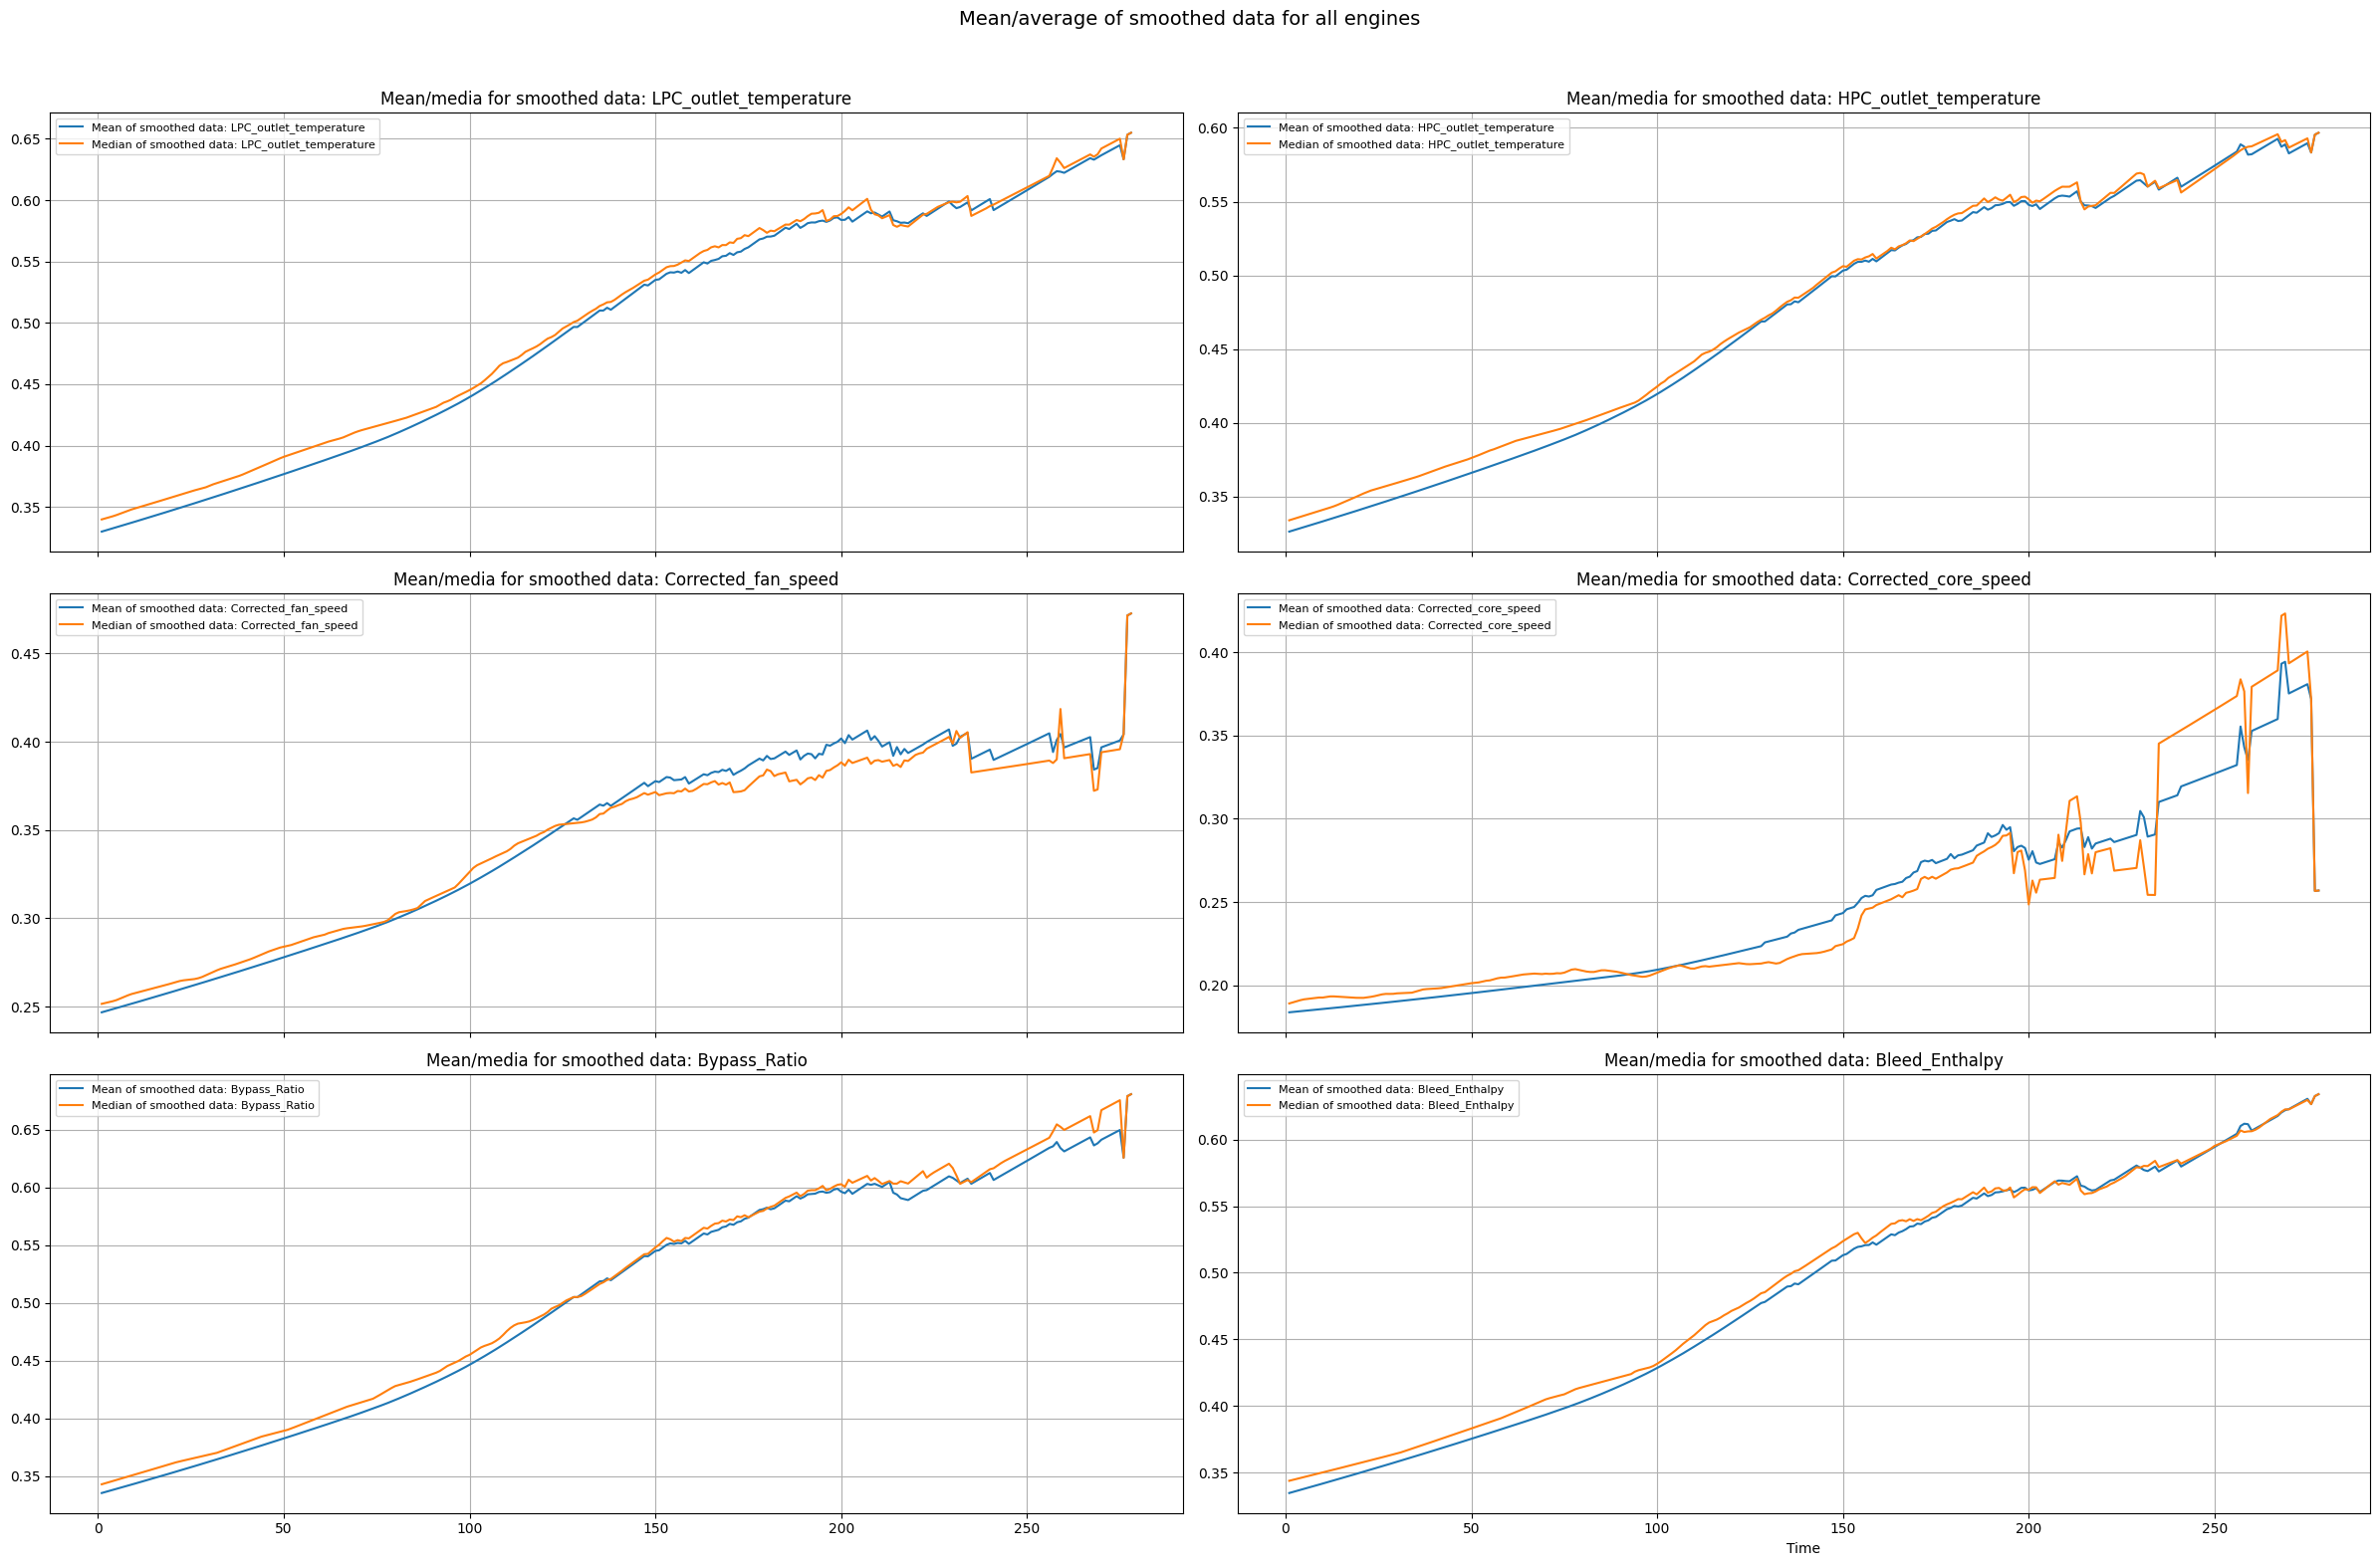

In [53]:
df_smooth = utils.lowess_features_overwrite(df)
utils.draw_time_series_for_all_engines(df_smooth)

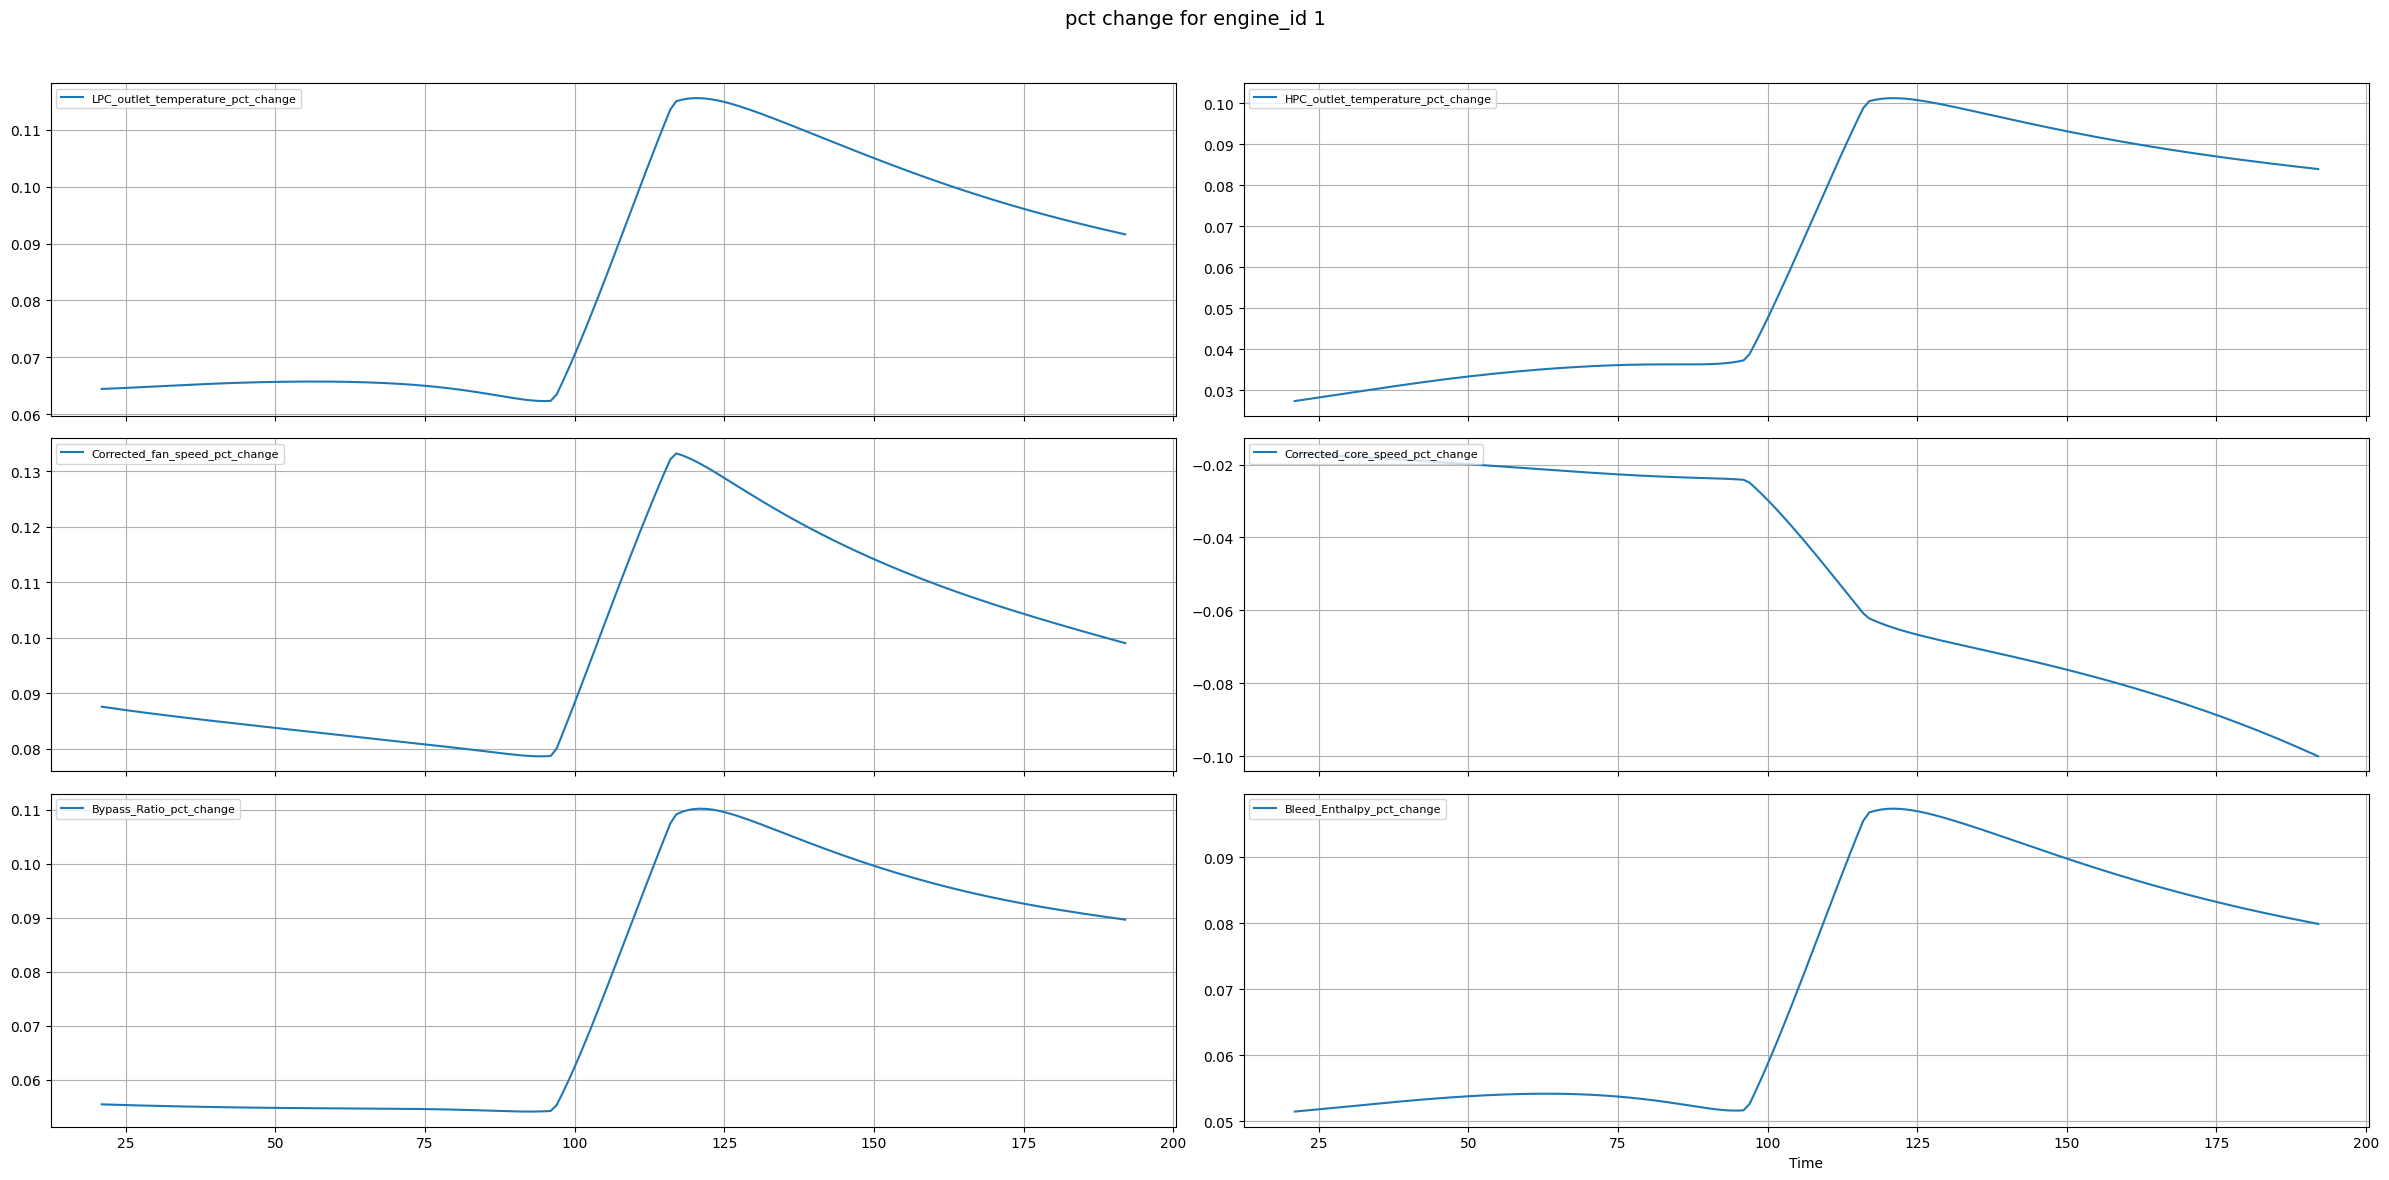

In [54]:
df_with_pctchange = pct_change(df_smooth, PCT_CHANGE_PERIODS)
df_with_pctchange['rul'] = df.groupby('engine_id')['time'].transform('max') - df['time']
draw_pct_change(df_with_pctchange, ENGINE_ID)


### Mean RUL - to cut off high predictions

In [55]:
from numpy import ceil

MAX_RUL = int(ceil(df_with_pctchange.loc[df_with_pctchange.groupby('engine_id')['rul'].idxmax()]['rul'].mean()))
print(MAX_RUL)

177


In [56]:
features = list(df_with_pctchange.columns)
features.remove('engine_id')
y = df_with_pctchange.groupby('engine_id')['time'].transform('max') - df_with_pctchange['time']
X = df_with_pctchange[features].drop(['rul'], axis=1)
X

,time,LPC_outlet_temperature,HPC_outlet_temperature,Corrected_fan_speed,Corrected_core_speed,Bypass_Ratio,Bleed_Enthalpy,LPC_outlet_temperature_pct_change,HPC_outlet_temperature_pct_change,Corrected_fan_speed_pct_change,Corrected_core_speed_pct_change,Bypass_Ratio_pct_change,Bleed_Enthalpy_pct_change
20,21,0.312707,0.329821,0.237028,0.169829,0.331546,0.315249,0.064433,0.027306,0.087556,-0.016927,0.055483,0.051481
21,22,0.313692,0.330302,0.238008,0.169676,0.332437,0.316055,0.064474,0.027519,0.087399,-0.017011,0.055448,0.051564
22,23,0.314682,0.330788,0.238990,0.169522,0.333330,0.316865,0.064518,0.027733,0.087245,-0.017097,0.055414,0.051648
23,24,0.315675,0.331277,0.239975,0.169368,0.334225,0.317678,0.064563,0.027948,0.087093,-0.017185,0.055380,0.051733
24,25,0.316673,0.331772,0.240963,0.169213,0.335122,0.318494,0.064610,0.028164,0.086944,-0.017274,0.055348,0.051820
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,196,0.645888,0.604129,0.482667,0.215763,0.667626,0.611773,0.073688,0.067781,0.082971,-0.007572,0.080581,0.062104
20627,197,0.648142,0.606080,0.484552,0.215674,0.670169,0.613596,0.073537,0.067668,0.082786,-0.007628,0.080431,0.062031
20628,198,0.650399,0.608034,0.486441,0.215585,0.672718,0.615422,0.073387,0.067556,0.082602,-0.007686,0.080280,0.061957
20629,199,0.652659,0.609991,0.488332,0.215495,0.675271,0.617252,0.073239,0.067443,0.082419,-0.007743,0.080130,0.061884


In [57]:
# split train and test data
TEST_SIZE = 0.1
unique_engine_ids = df_with_pctchange['engine_id'].unique()

test_engine_ids = pd.Series(unique_engine_ids).sample(frac=TEST_SIZE, random_state=42).values
test_df = df_with_pctchange[df_with_pctchange['engine_id'].isin(test_engine_ids)]
train_df = df_with_pctchange[~df_with_pctchange['engine_id'].isin(test_engine_ids)]

# shuffle data
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

X_train = train_df.drop(["engine_id", "rul"], axis=1)
y_train = train_df['rul']
X_test = test_df.drop(["engine_id", "rul"], axis=1)
y_test = test_df['rul']
X_train

,time,LPC_outlet_temperature,HPC_outlet_temperature,Corrected_fan_speed,Corrected_core_speed,Bypass_Ratio,Bleed_Enthalpy,LPC_outlet_temperature_pct_change,HPC_outlet_temperature_pct_change,Corrected_fan_speed_pct_change,Corrected_core_speed_pct_change,Bypass_Ratio_pct_change,Bleed_Enthalpy_pct_change
0,132,0.405965,0.418410,0.206874,0.384572,0.400357,0.420333,0.131313,0.109871,0.099826,0.137359,0.120416,0.119666
1,168,0.638465,0.582951,0.517377,0.153203,0.656205,0.588009,0.081450,0.073101,0.104909,-0.089975,0.084763,0.076667
2,28,0.407230,0.374470,0.320310,0.130303,0.404984,0.386653,0.036121,0.039929,0.011256,0.135368,0.034263,0.035288
3,148,0.505810,0.468145,0.356818,0.235932,0.509483,0.488839,0.040815,0.029008,0.007690,0.086250,0.040656,0.033207
4,130,0.557668,0.512170,0.456677,0.136084,0.580697,0.525112,0.066296,0.055668,0.056807,0.007767,0.057820,0.054851
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14878,121,0.488747,0.467337,0.313245,0.298081,0.503202,0.482845,0.088983,0.077487,0.045527,0.142725,0.086503,0.082206
14879,38,0.306171,0.320930,0.247715,0.162162,0.312834,0.296427,0.073744,0.050124,0.045718,0.023018,0.069015,0.061553
14880,145,0.563364,0.540854,0.392961,0.269406,0.572046,0.535552,0.101332,0.099382,0.080609,0.078367,0.097456,0.096196
14881,136,0.388332,0.385319,0.255013,0.257915,0.401119,0.405561,0.061525,0.053094,0.081330,0.000880,0.064311,0.065713


In [58]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

In [59]:
from mapie.regression import MapieRegressor

mapie_reg = MapieRegressor(estimator=model)
mapie_reg = mapie_reg.fit(X_train, y_train)

result = mapie_reg.predict(X_test, alpha=MAPIE_ALPHAS)
y_pred = result[0]
utils.evaluate(y_test, y_pred)

test set RMSE:17.77900522816006, R2:0.8689459755611713


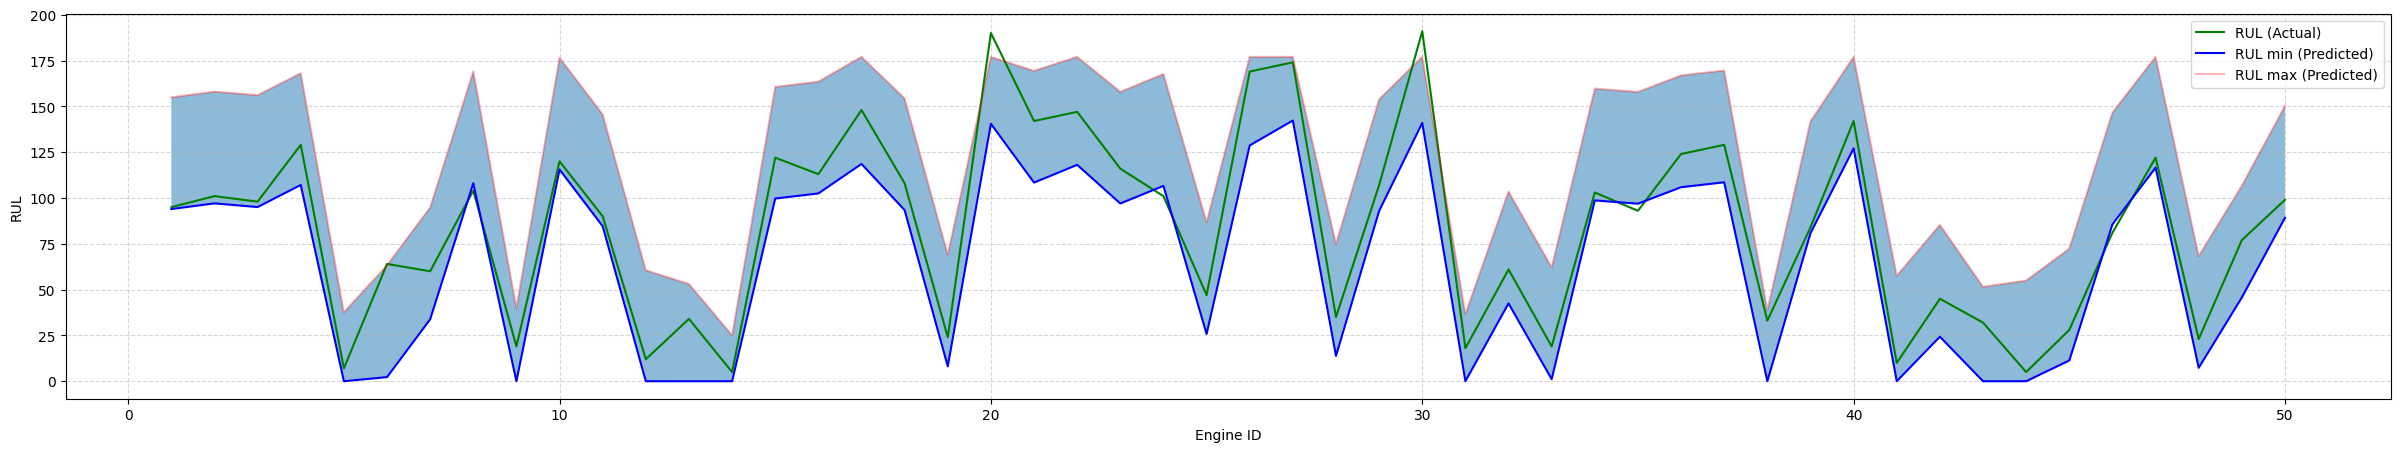

In [60]:
utils.evaluate_mapie_output(result, y_test, MAX_RUL, draw_size=50)

In [61]:
#jaka metryka do modelu???
# ile cykli, żeby sensownie oszacować RUL?
# odciąć dane przed progiem pochodnej

### Validation data

In [62]:
val_df = utils.load_data("CMAPSSData/test_FD001.txt")
val_y = pd.read_csv("CMAPSSData/RUL_FD001.txt", sep=" ", header=None)
val_y.drop(axis=1, columns=[1], inplace=True)
features_to_keep = ['engine_id', 'time', 'LPC_outlet_temperature', 'HPC_outlet_temperature', 'Corrected_fan_speed',
                    'Corrected_core_speed',
                    'Bypass_Ratio', 'Bleed_Enthalpy']
val_df = val_df[features_to_keep]
features = list(val_df.columns)
features.remove('time')
features.remove('engine_id')
val_df[features] = scaler.transform(val_df[features])
val_df_smooth = utils.lowess_features_overwrite(val_df)
val_df_pct_change = pct_change(val_df_smooth, PCT_CHANGE_PERIODS)
val_df_pct_change

,engine_id,time,LPC_outlet_temperature,HPC_outlet_temperature,Corrected_fan_speed,Corrected_core_speed,Bypass_Ratio,Bleed_Enthalpy,LPC_outlet_temperature_pct_change,HPC_outlet_temperature_pct_change,Corrected_fan_speed_pct_change,Corrected_core_speed_pct_change,Bypass_Ratio_pct_change,Bleed_Enthalpy_pct_change
20,1,21,0.337353,0.309998,0.265951,0.158900,0.357803,0.317455,0.063160,-0.005044,0.087144,-0.024570,0.176100,0.016994
21,1,22,0.339073,0.310570,0.267397,0.158821,0.358102,0.321141,0.066779,-0.000852,0.088824,-0.024599,0.162388,0.035563
22,1,23,0.340767,0.311096,0.268871,0.158734,0.358305,0.324962,0.069815,0.002964,0.090723,-0.024527,0.148923,0.054138
23,1,24,0.342362,0.311602,0.270384,0.158647,0.358414,0.328904,0.072027,0.006510,0.092868,-0.024299,0.135677,0.072675
24,1,25,0.343816,0.312096,0.271941,0.158566,0.358433,0.332945,0.073307,0.009876,0.095254,-0.023867,0.122669,0.091142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.491154,0.478448,0.234409,0.420268,0.475899,0.478287,0.077268,0.065841,0.012287,0.104489,0.067335,0.069241
13092,100,195,0.492956,0.479965,0.234561,0.422304,0.477435,0.479870,0.077137,0.065795,0.012355,0.104209,0.067260,0.069144
13093,100,196,0.494762,0.481486,0.234715,0.424345,0.478974,0.481457,0.077007,0.065750,0.012426,0.103928,0.067186,0.069050
13094,100,197,0.496572,0.483012,0.234869,0.426390,0.480517,0.483048,0.076881,0.065705,0.012498,0.103646,0.067112,0.068959


In [63]:
max_time_df = val_df_pct_change.loc[val_df_pct_change.groupby('engine_id')['time'].idxmax()]
X = max_time_df.drop(['engine_id'], axis=1)
X

,time,LPC_outlet_temperature,HPC_outlet_temperature,Corrected_fan_speed,Corrected_core_speed,Bypass_Ratio,Bleed_Enthalpy,LPC_outlet_temperature_pct_change,HPC_outlet_temperature_pct_change,Corrected_fan_speed_pct_change,Corrected_core_speed_pct_change,Bypass_Ratio_pct_change,Bleed_Enthalpy_pct_change
30,31,0.349158,0.314980,0.282112,0.158596,0.357457,0.357462,0.066235,0.029989,0.111669,-0.014939,0.051555,0.195428
79,49,0.468276,0.389134,0.351670,0.142396,0.451429,0.384183,0.118045,-0.028920,0.039120,-0.029682,0.045833,-0.046847
205,126,0.508639,0.470131,0.406872,0.149452,0.528350,0.474763,0.052877,0.036185,0.046836,-0.021691,0.050508,0.025655
311,106,0.482268,0.457089,0.353505,0.176916,0.480398,0.450965,0.066360,0.044476,0.032547,0.010988,0.047564,0.036285
409,98,0.441711,0.424483,0.362591,0.155414,0.469046,0.447251,0.015666,0.018265,0.040704,-0.030591,0.042815,0.041108
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12545,97,0.326259,0.331249,0.210254,0.250630,0.311969,0.323445,0.069217,0.028748,0.056286,0.001224,0.027821,0.027866
12679,134,0.366202,0.367464,0.245830,0.272819,0.366370,0.411363,0.029809,0.038900,0.048761,0.023924,0.038069,0.057030
12800,121,0.444578,0.464080,0.332591,0.214318,0.485823,0.440220,0.044834,0.066403,0.053065,0.004830,0.070122,0.042242
12897,97,0.310525,0.295484,0.182399,0.252315,0.289273,0.264403,0.089462,0.005131,0.023482,0.037804,0.024452,-0.022748


In [64]:
result = mapie_reg.predict(X, alpha=MAPIE_ALPHAS)

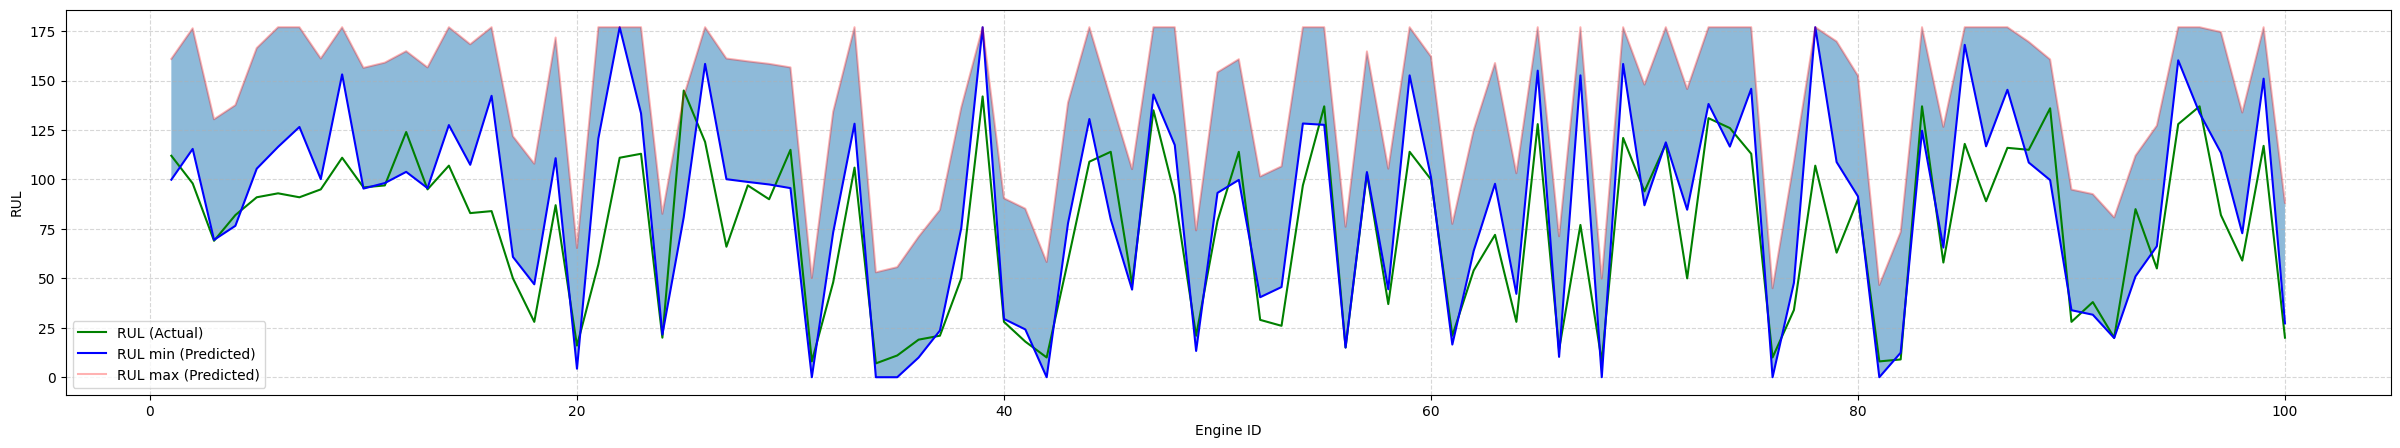

In [65]:
utils.evaluate_mapie_output(result, val_y, MAX_RUL)